In [1]:
import pandas as pd
import numpy as np
import datetime
% matplotlib inline

# 資料讀取和基本觀察

In [2]:
rating = pd.read_csv('ml-latest-small/ratings.csv')
rating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


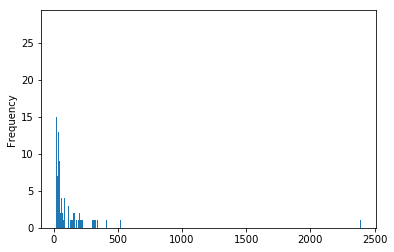

In [3]:
rating.userId.value_counts().plot(kind='hist',bins=2480)

In [4]:
rating.userId.value_counts().min()

20

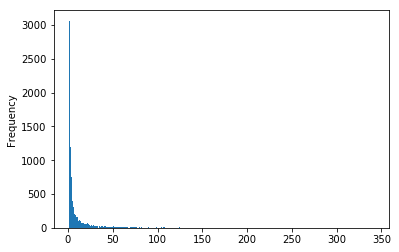

In [5]:
rating.movieId.value_counts().plot(kind='hist',bins=350)

In [6]:
rating.movieId.value_counts().min()

1

In [7]:
rating.movieId.value_counts()

356       341
296       324
318       311
593       304
260       291
480       274
2571      259
1         247
527       244
589       237
1196      234
110       228
1270      226
608       224
2858      220
1198      220
780       218
1210      217
588       215
457       213
2959      202
590       202
50        201
47        201
4993      200
858       200
150       200
364       200
380       198
32        196
         ... 
98160       1
6109        1
120805      1
131168      1
73860       1
60674       1
104595      1
133281      1
155820      1
26797       1
47287       1
8420        1
61250       1
3870        1
5917        1
1759        1
26323       1
32464       1
65216       1
65088       1
73276       1
7708        1
69118       1
110058      1
140763      1
48520       1
111913      1
1311        1
27922       1
2049        1
Name: movieId, Length: 9066, dtype: int64

# Memory-based CF

In [8]:
user_avg_r = {}
item_avg_r = {}
rating_dict = {}
for i in range(len(rating)):
    uid = rating.userId[i]
    mid = rating.movieId[i]
    rat = rating.rating[i]
    user_avg_r[uid] = user_avg_r.get(uid,0)+rat
    item_avg_r[mid] = item_avg_r.get(mid,0)+rat
    rating_dict[uid] = rating_dict.get(uid,{})
    rating_dict[uid][mid] = rating_dict[uid].get(mid,rat)

userN = rating.userId.value_counts()    
movieN = rating.movieId.value_counts()

for i in userN.index:
    user_avg_r[i] = user_avg_r[i]/userN[i]
for i in movieN.index:
    item_avg_r[i] = item_avg_r[i]/movieN[i]


In [9]:
testuid = 1
testmid = 1
rating_dict[testuid].get(testmid,-1)

-1

In [10]:
subrating = rating[rating.movieId==testmid]
subrating.head()

,userId,movieId,rating,timestamp
495,7,1,3.0,851866703
699,9,1,4.0,938629179
889,13,1,5.0,1331380058
962,15,1,2.0,997938310
3105,19,1,3.0,855190091


In [11]:
sims = {}
for user in subrating.userId:
    Auserrating = rating[rating.userId==testuid]
    Buserrating = rating[rating.userId==user]
    
    Auserrating = Auserrating[Auserrating.movieId.isin(Buserrating.movieId)].sort_values('movieId')
    Buserrating = Buserrating[Buserrating.movieId.isin(Auserrating.movieId)].sort_values('movieId')
    if len(Auserrating)<=2:
        sim=0
    else:
        Arat = Auserrating.rating.reset_index(drop=True)
        Brat = Buserrating.rating.reset_index(drop=True)
    
        sim = sum(Arat*Brat)/np.sqrt(sum(Arat**2)*sum(Brat**2))
    sims[user] = sim


In [12]:
top = 0
bottom = 0
for user in subrating.userId:
    if sims[user] == 0:
        continue
    top += sims[user]*(rating_dict[user][testmid] - user_avg_r[user])
    bottom += sims[user]
user_avg_r[testuid]+top/bottom

2.8648745144961811

# matrix factorization

In [29]:
def matrix_factorization(R, P, Q, K, steps=30, alpha=0.0005, beta=0.01):
    Pdelta = 0
    Qdelta = 0
    strange = 1
    # original GD
    for step in range(steps):
        e = 0
        ist = 0
        ien = strange
        
        while True:
            i = ist
            if ist % 50000 == 0:
                print(datetime.datetime.now().time())
                
            uid = R[i,0]
            mid = R[i,1]
            Pt = P[uid,:].copy()
            Qt = Q[mid,:].copy()
            
            eij = R[i,2] - np.sum(Pt*Qt)
            e = e + np.sum(np.power(eij, 2))
            e = e + (beta/2) * np.sum(np.power(Pt,2) + np.power(Qt,2))
            
            Pdelta = alpha * (2 * np.tile(eij,(K,1)).T * Qt - beta * Pt)
            Qdelta = alpha * (2 * np.tile(eij,(K,1)).T * Pt - beta * Qt)
            

            P[uid,:] = P[uid,:] + Pdelta
            Q[mid,:] = Q[mid,:] + Qdelta

            
            ist+=strange
            if ist == R.shape[0]:
                break
        #np.savetxt("PP.csv", P, delimiter=",")
        #np.savetxt("QQ.csv", Q, delimiter=",")
        if e < 6000:
            break
        else:
            print(e,datetime.datetime.now().time())
    return P, Q


In [30]:
K = 24
M = rating.userId.max()+1
N = rating.movieId.max()+1
P = np.random.rand(M,K)
Q = np.random.rand(N,K)

a = rating[['userId','movieId']].values.T
b = (rating.rating.values*10).round().astype(np.int64).reshape(1,-1)
R = np.concatenate((a,b),axis=0).T

In [31]:
nP, nQ = matrix_factorization(R, P, Q, K)

14:10:13.138438
14:10:16.627026
14:10:20.148647
22608736.2317 14:10:20.149150
14:10:20.149150
14:10:23.623304
14:10:27.227339
11709915.8312 14:10:27.227840
14:10:27.227840
14:10:30.822703
14:10:34.311556
8836669.1429 14:10:34.312563
14:10:34.312563
14:10:37.685317
14:10:41.196905
8020207.97384 14:10:41.197420
14:10:41.197420
14:10:44.599093
14:10:48.042524
7559551.2888 14:10:48.043028
14:10:48.043028
14:10:51.420456
14:10:54.893997
7208746.73902 14:10:54.894974
14:10:54.894974
14:10:58.420371
14:11:02.100331
6877876.7353 14:11:02.100843
14:11:02.100843
14:11:05.602650
14:11:09.057029
6529319.96761 14:11:09.057029
14:11:09.057029
14:11:12.590051
14:11:16.096525
6160691.87501 14:11:16.097027
14:11:16.097529
14:11:19.552315
14:11:23.104079
5792084.04442 14:11:23.104580
14:11:23.104580
14:11:26.488718
14:11:29.872267
5441825.06377 14:11:29.872769
14:11:29.872769
14:11:33.348191
14:11:37.061040
5114983.56488 14:11:37.062018
14:11:37.062018
14:11:40.579104
14:11:44.077624
4811402.57606 14:11

In [32]:
result = []
for i in range(len(rating)):
    result.append(np.dot(P[rating.userId[i]],Q[rating.movieId[i]])/10.0)
rating['result'] = result

In [33]:
rating.head()

,userId,movieId,rating,timestamp,result
0,1,31,2.5,1260759144,2.570766
1,1,1029,3.0,1260759179,2.667015
2,1,1061,3.0,1260759182,2.495136
3,1,1129,2.0,1260759185,2.459951
4,1,1172,4.0,1260759205,3.193422


In [36]:
th = 0.5
((rating['rating']-rating['result']<th)&
 (rating['rating']-rating['result']>-th)).value_counts()

True     75458
False    24546
dtype: int64

# 加速

In [37]:
def matrix_factorization2(R, P, Q, K, steps=100, alpha=0.0005, beta=0.01):
    Pdelta = 0
    Qdelta = 0
    strange = 100
    # original GD
    for step in range(steps):
        e = 0
        ist = 0
        ien = strange
        
        while True:
            if ien > R.shape[0]:
                ien = R.shape[0] 
            i = [n for n in range(ist,ien)]
            #if ist % 50000 == 0:
            #    print(datetime.datetime.now().time())
                
            uid = R[i,0]
            mid = R[i,1]
            Pt = P[uid,:].copy()
            Qt = Q[mid,:].copy()
            
            eij = R[i,2] - np.sum(Pt*Qt,axis=1)
            e = e + np.sum(np.power(eij, 2))
            e = e + (beta/2) * np.sum(np.power(Pt,2) + np.power(Qt,2))
            
            Pdelta = alpha * (2 * np.tile(eij,(K,1)).T * Qt - beta * Pt)
            Qdelta = alpha * (2 * np.tile(eij,(K,1)).T * Pt - beta * Qt)

            uquid = np.unique(uid)
            Psums = []
            for idx in uquid:
                Psums.append(Pdelta[uid == idx,:].sum(axis=0))
            Psums = np.array(Psums)
            
            uqmid = np.unique(mid)
            Qsums = []
            for idx in uqmid:
                Qsums.append(Qdelta[mid == idx,:].sum(axis=0))
            Qsums = np.array(Qsums)
            
            P[uquid,:] = P[uquid,:] + Psums
            Q[uqmid,:] = Q[uqmid,:] + Qsums


            if ien == R.shape[0]:
                break
            ist+=strange
            ien+=strange
        #np.savetxt("PP.csv", P, delimiter=",")
        #np.savetxt("QQ.csv", Q, delimiter=",")
        if e < 6000:
            break
        elif step%5 == 0:
            print(e,datetime.datetime.now().time())
    return P, Q


In [38]:
K = 24
M = rating.userId.max()+1
N = rating.movieId.max()+1
P = np.random.rand(M,K)
Q = np.random.rand(N,K)

a = rating[['userId','movieId']].values.T
b = (rating.rating.values*10).round().astype(np.int64).reshape(1,-1)
R = np.concatenate((a,b),axis=0).T

In [39]:
nP, nQ = matrix_factorization2(R, P, Q, K)

37633065.1462 15:18:24.564278
7303171.216 15:18:30.375659
5571367.37198 15:18:36.161599
4172659.2313 15:18:41.735108
3315740.69795 15:18:47.390938
2786906.2802 15:18:53.084051
2439050.6983 15:18:58.754822
2198398.60611 15:19:04.619350
2024597.50663 15:19:10.367000
1894210.50624 15:19:16.143601
1793120.25099 15:19:21.841238
1712529.54759 15:19:27.654587
1646756.76085 15:19:33.282024
1592003.09679 15:19:39.117877
1545647.13035 15:19:44.905338
1505828.01636 15:19:50.611877
1471191.75535 15:19:56.369562
1440732.21137 15:20:02.083302
1413688.27676 15:20:07.889107
1389475.08569 15:20:13.764415


In [40]:
result = []
for i in range(len(rating)):
    result.append(np.dot(P[rating.userId[i]],Q[rating.movieId[i]])/10.0)
rating['result'] = result

In [41]:
rating.head()

,userId,movieId,rating,timestamp,result
0,1,31,2.5,1260759144,2.818670
1,1,1029,3.0,1260759179,2.874687
2,1,1061,3.0,1260759182,3.289053
3,1,1129,2.0,1260759185,2.582534
4,1,1172,4.0,1260759205,3.598834


In [45]:
th = 1
((rating['rating']-rating['result']<th)&
 (rating['rating']-rating['result']>-th)).value_counts()

True     98203
False     1801
dtype: int64